# MODULES

In [ ]:
# Import Required Modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Categorical encoder
from sklearn.preprocessing import LabelEncoder

# Counter for lists
from collections import Counter

# Models going to be used
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import and mount to access drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# DATA PRE-PROCESSING AND VISUALISATION

In [ ]:
# Create a data-frame of ratings
df = pd.read_csv('/gdrive/MyDrive/ratings.csv')

# Dropping timestamp as it isn't required
df = df.drop(columns = 'timestamp')

# Checking
df.sample(5)

,userId,movieId,rating
5031,33,1,3.0
26909,182,5522,3.5
73374,474,1082,3.5
83796,534,35836,4.0
9846,64,6188,5.0


In [ ]:
# min and max values of ratings
print('min rating is : ', np.min(df['rating'].to_numpy()))
print('max rating is : ', np.max(df['rating'].to_numpy()))

min rating is :  0.5
max rating is :  5.0


In [ ]:
# Convert the df into more easily understable format (pivot table)
df1 = df.pivot_table(index='movieId', columns='userId', values='rating')

# Now that min rating given is 0.5 so let's just
# replace the Nan values with 0 {easy understanding}
# So 0 means it is unwatched by the user
df1.fillna(0, inplace=True)

# Checking
df1

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Not all the users and the movies are trustworthy
* What I mean by that is say there is a movie that is only watched and rated by 2 or 5 users it is not so popular meaning it won't interest the larges mass
* Similar thing can be said for the sake of users where is a user only rated 10 movies he might not be such a truth worth critique whose opinion matters or is valuable
* Hence we will consider only those movies which have been rated by atleast 10 users and users who have atleast rated 50 movies

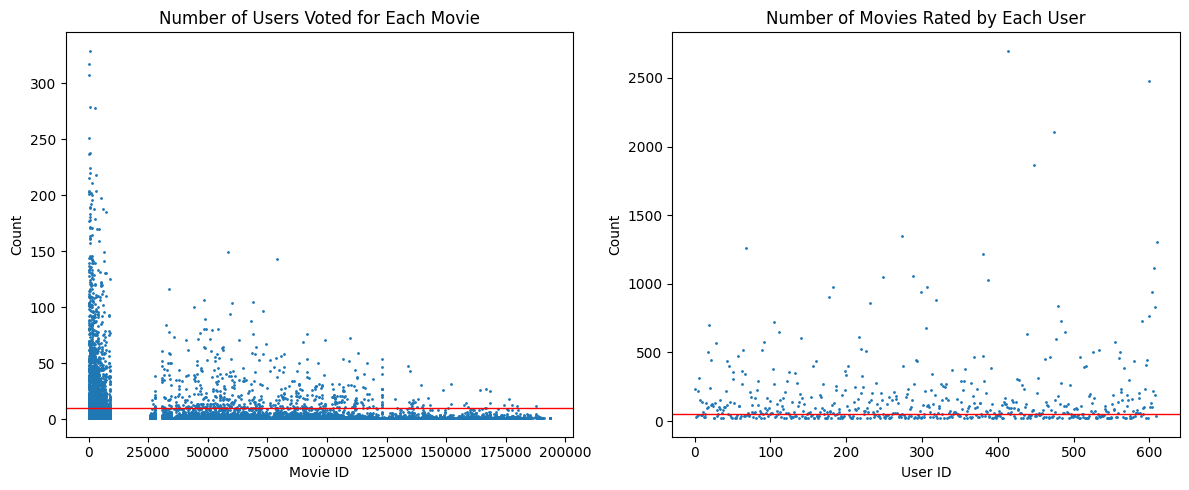

In [ ]:
# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Get the usercount of each movieId
no_user_voted = df['movieId'].value_counts()

# Plot the first scatter plot
axs[0].scatter(no_user_voted.index, no_user_voted, s=1)
axs[0].axhline(y=10, color='r', linestyle='-', linewidth=1)
axs[0].set_title('Number of Users Voted for Each Movie')
axs[0].set_xlabel('Movie ID')
axs[0].set_ylabel('Count')

# Get the user rated movies count of eachId
no_movies_voted = df['userId'].value_counts()

# Plot the second scatter plot
axs[1].scatter(no_movies_voted.index, no_movies_voted, s=1)
axs[1].axhline(y=50, color='r', linestyle='-', linewidth=1)
axs[1].set_title('Number of Movies Rated by Each User')
axs[1].set_xlabel('User ID')
axs[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Get the rows and columns that are to be kept
rows_to_keep = no_user_voted[no_user_voted > 10].index
columns_to_keep = no_movies_voted[no_movies_voted > 50].index

# Extract them from the df1 and overwrite it
#df1.columns = df1.columns.astype(str).tolist()
df1 = df1.loc[rows_to_keep, columns_to_keep]

# Final dataset to be used for model after sorting
df1 = df1.sort_index(axis=1).sort_index(axis=0)

# Create a dictionary of all those movieId based on userId as key
indices = {}
for column in df1.columns:
    indices[column] = df1[df1[column] != 0].index.tolist()

In [ ]:
# sample space of all movies after filtering
all_movies = []
for index, row in df1.iterrows():
    all_movies.append(index)

In [ ]:
# The second_data represents the informations/features of movies
df2 = pd.read_csv('/gdrive/MyDrive/data_prml_2')
df2 = df2.drop(columns = df2.columns[0])

# Make sure the movies which don't meet the criteria are removed
to_keep = []
for index, row in df2.iterrows():
    if row[0] in all_movies:
        to_keep.append(index)

df2 = df2.iloc[to_keep]
df2

,movieId,genres,Year,Director,Stars
0,1,adventure,1995,johnlasseter,tomhanks
1,1,adventure,1995,johnlasseter,timallen
2,1,adventure,1995,johnlasseter,donrickles
3,1,adventure,1995,johnlasseter,jimvarney
4,1,animation,1995,johnlasseter,tomhanks
...,...,...,...,...,...
96868,187593,comedy,2018,davidleitch,juliandennison
96869,187593,sci-fi,2018,davidleitch,ryanreynolds
96870,187593,sci-fi,2018,davidleitch,joshbrolin
96871,187593,sci-fi,2018,davidleitch,morenabaccarin


In [ ]:
# Categorical encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# For each column except movieId
df2['genres'] = label_encoder.fit_transform(df2['genres'].to_list())
df2['Year'] = label_encoder.fit_transform(df2['Year'].to_list())
df2['Director'] = label_encoder.fit_transform(df2['Director'].to_list())
df2['Stars'] = label_encoder.fit_transform(df2['Stars'].to_list())

# Final data
df2

,movieId,genres,Year,Director,Stars
0,1,1,61,466,3698
1,1,1,61,466,3658
2,1,1,61,466,998
3,1,1,61,466,1781
4,1,2,61,466,3698
...,...,...,...,...,...
96868,187593,4,84,193,1993
96869,187593,15,84,193,3324
96870,187593,15,84,193,1958
96871,187593,15,84,193,2739


In [ ]:
# Get userId
userId = int(input("Enter USER_ID : "))

Enter USER_ID : 6


 **CLASSIFICATIONS**
* All the ratings will be undergoing a ceil
* As a result there will be 5 classes ranging from 1 - 5

**REGRESSION**
* No change

In [ ]:
# Movies watched will be train data
# Movies rated 0 meaning not watched will be the test data

# Train data : get movieId of watched movies
X = indices[userId]
y = [df1.loc[i, userId] for i in X]

# classify the rating
Y = []
for i in y:
  if float(i) == 0.5:
      Y.append(1)
  elif float(i) == 1.5:
      Y.append(2)
  elif float(i) == 2.5:
      Y.append(3)
  elif float(i) == 3.5:
      Y.append(4)
  elif float(i) == 4.5:
      Y.append(5)
  else:
        Y.append(float(i))
y = Y

In [ ]:
# user ratings of movies
counter = Counter(y)
print(counter)

Counter({3.0: 88, 4.0: 76, 5.0: 40, 2.0: 12, 1.0: 4})


In [ ]:
# Create two data_frames for train and test
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [ ]:
for index, row in df2.iterrows():
    # Make a row to append in df
    r = [row[i] for i in range(1, 5)]

    if row[0] in X: # Meaning it is a train data
        r.append(y[X.index(row[0])])
        df_train = pd.concat([df_train, pd.DataFrame([r])], ignore_index=True)
    else: # Meaning it is a test data make sure you include MovieId
        r.insert(0, row[0])
        df_test = pd.concat([df_test, pd.DataFrame([r])], ignore_index=True)

In [ ]:
# Change columns
# train
col = df2.columns[1:].to_list()
col.append('target')
df_train.columns = col

# Test
df_test.columns = df2.columns

In [ ]:
# Fianl training data
df_train.sample(5)

,genres,Year,Director,Stars,target
1947,12,5,980,1030,4.0
484,18,61,786,3339,3.0
1039,4,60,420,3678,4.0
2210,14,62,550,1155,4.0
1766,1,58,812,2304,5.0


In [ ]:
# Convert to numpy
X_train = df_train.to_numpy()

# For target just take last column
y_train = X_train[:, -1]
X_train = X_train[:, :-1]

In [ ]:
# Final testing data
df_test.sample(5)

,movieId,genres,Year,Director,Stars
10252,3159,12,65,224,347
13233,4881,7,67,435,375
13330,4890,14,67,710,1524
17086,34319,15,71,615,1174
11418,3638,16,45,563,3243


In [ ]:
# Now for the sake of testing
X_test = df_test.to_numpy()

# seperate the movieId which will helps us later
ids = X_test[:,0]
X_test = X_test[:,1:]

In [ ]:
X_test

array([[   1,   61,  466, 3698],
       [   1,   61,  466, 3658],
       [   1,   61,  466,  998],
       ...,
       [  15,   84,  193, 1958],
       [  15,   84,  193, 2739],
       [  15,   84,  193, 1993]])

In [ ]:
# Get data about movies
Data = pd.read_csv('/gdrive/MyDrive/data_prml_.csv')
Data = Data.drop(columns = 'Keywords')

#NAIVE BAYES

In [ ]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Now for the sake of testing
X_test = df_test.to_numpy()

# seperate the movieId which will helps us later
ids = X_test[:,0]
X_test = X_test[:,1:]

In [ ]:
# Predicted ratings
pred = model.predict(X_test)
pred

array([5., 5., 5., ..., 3., 3., 3.])

In [ ]:
np.unique(pred)

array([1., 2., 3., 4., 5.])

In [ ]:
# Get corresponding posterior_probabilities
prob = model.predict_proba(X_test)
prob

array([[6.39936841e-002, 2.51177186e-001, 1.15958269e-001,
        7.85052482e-002, 4.90365612e-001],
       [6.47377307e-002, 2.50374124e-001, 1.15951309e-001,
        7.86218260e-002, 4.90315011e-001],
       [1.29538881e-001, 2.71519534e-001, 1.09452054e-001,
        1.06159046e-001, 3.83330485e-001],
       ...,
       [0.00000000e+000, 5.04251123e-112, 5.03372805e-001,
        4.96627195e-001, 1.66103067e-011],
       [0.00000000e+000, 5.09874794e-112, 5.29330587e-001,
        4.70669413e-001, 1.84453732e-011],
       [0.00000000e+000, 5.04125293e-112, 5.04769539e-001,
        4.95230461e-001, 1.67084030e-011]])

In [ ]:
# Get movies that we will now see if to recommend or not
movies_to_check = np.unique(ids)
recom = {}

for mov in movies_to_check:
    # Get where they are in test
    indi = np.where(ids == mov)[0]
    # Get the mean probabilities the same movie
    p = prob[indi].mean(axis = 0)
    if np.argmax(p) == len(p) - 1:
            recom[mov] = p[np.argmax(p)]

# If there are not enough 5 rated movies
if(len(recom) < 5):
    for mov in movies_to_check:
        # Get where they are in test
        indi = np.where(ids == mov)[0]
        # Get the mean probabilities the same movie
        p = prob[indi].mean(axis = 0)
        if np.argmax(p) == len(p) - 2:
            recom[mov] = p[np.argmax(p)]

In [ ]:
# Get movieId of top 5 movies
recom = sorted(recom.items(), key=lambda x: x[1], reverse=True)
recom = recom[:5]
recom = [i[0] for i in recom]

In [ ]:
# final indices
yaho = Data[Data['movieId'].isin(recom)].index

# Slicing and reordering the index
df_nb = Data.iloc[yaho]
df_nb = df_nb.reset_index(drop=True)
df_nb.index = df_nb.index + 1

# Recommendation
df_nb

,movieId,genres,Title,Year,imdbId,tmdbId,Director,Stars
1,373,['Thriller'],Red Rock West,1992,105226,10427.0,['John Dahl'],"['Nicolas Cage', 'Craig Reay', 'Vance Johnson'..."
2,1343,['Thriller'],Cape Fear,1991,101540,1598.0,['Martin Scorsese'],"['Robert De Niro', 'Nick Nolte', 'Jessica Lang..."
3,1408,"['Action', 'Romance', 'War', 'Western']","Last of the Mohicans, The",1992,104691,9361.0,['Michael Mann'],"['Daniel Day-Lewis', 'Madeleine Stowe', 'Russe..."
4,2108,"['Comedy', 'Romance']",L.A. Story,1991,102250,2107.0,['Mick Jackson'],"['Steve Martin', 'Victoria Tennant', 'Richard E']"
5,2822,"['Adventure', 'Romance']",Medicine Man,1992,104839,9096.0,['John McTiernan'],"['Sean Connery', 'Lorraine Bracco', 'José Wilk..."


# SVM

In [ ]:
# Create an instance
clf = SVC(probability=True)

# Model training
clf.fit(X_train, y_train)

SVC(probability=True)

In [ ]:
# Predicted ratings
pred = clf.predict(X_test)
print(pred)

[3. 3. 4. ... 3. 3. 3.]


In [ ]:
np.unique(pred)

array([3., 4.])

In [ ]:
# Get corresponding posterior_probabilities
prob = clf.predict_proba(X_test)
prob

array([[0.015779  , 0.04847403, 0.37572885, 0.32189003, 0.23812809],
       [0.01592754, 0.04710151, 0.37364252, 0.32314587, 0.24018255],
       [0.01358968, 0.04968085, 0.34215788, 0.37442265, 0.22014894],
       ...,
       [0.02110699, 0.04854759, 0.3876403 , 0.32255365, 0.22015147],
       [0.02679109, 0.04794983, 0.37369422, 0.32466807, 0.2268968 ],
       [0.02158427, 0.04859593, 0.38790854, 0.32174704, 0.22016422]])

In [ ]:
# Get movies that we will now see if to recommend or not
movies_to_check = np.unique(ids)
recom = {}

for mov in movies_to_check:
    # Get where they are in test
    indi = np.where(ids == mov)[0]
    # Get the mean probabilities of 0 and 1 for the same movie
    p = prob[indi].mean(axis = 0)
    if p[4] > p[0] and p[4] > p[1] and p[4] > p[2] and p[4] > p[3]:
        recom[mov] = p[4]

# If there are not enough 5 rated movies
if(len(recom) < 5):
    for mov in movies_to_check:
        # Get where they are in test
        indi = np.where(ids == mov)[0]
        # Get the mean probabilities the same movie
        p = prob[indi].mean(axis = 0)
        if p[3] > p[0] and p[3] > p[1] and p[3] > p[2]:
            recom[mov] = p[3]

# If there are not enough 4 rated movies
if(len(recom) < 5):
    for mov in movies_to_check:
        # Get where they are in test
        indi = np.where(ids == mov)[0]
        # Get the mean probabilities the same movie
        p = prob[indi].mean(axis = 0)
        if p[2] > p[0] and p[2] > p[1]:
            recom[mov] = p[3]

In [ ]:
# Get movieId of top 5 movies
recom = sorted(recom.items(), key=lambda x: x[1], reverse=True)
recom = recom[:5]
recom = [i[0] for i in recom]

In [ ]:
# final indices
yaho = Data[Data['movieId'].isin(recom)].index

# Slicing and reordering the index
df_nb = Data.iloc[yaho]
df_nb = df_nb.reset_index(drop=True)
df_nb.index = df_nb.index + 1

# Recommendation
df_nb

,movieId,genres,Title,Year,imdbId,tmdbId,Director,Stars
1,1991,"['Horror', 'Thriller']",Child's Play,1988,94862,10585.0,['Tom Holland'],"['Catherine Hicks', 'Chris Sarandon', 'Alex Vi..."
2,2391,"['Crime', 'Drama', 'Thriller']","Simple Plan, A",1998,120324,10223.0,['Sam Raimi'],"['Bill Paxton', 'Bridget Fonda', 'Billy Bob Th..."
3,2901,"['Horror', 'Sci-Fi']",Phantasm,1979,79714,9638.0,['Don Coscarelli'],['A']
4,4014,"['Drama', 'Romance']",Chocolat,2000,241303,392.0,['Lasse Hallström'],"['Alfred Molina', 'Carrie-Anne Moss', 'Aurelie..."
5,7439,"['Action', 'Crime', 'Thriller']","Punisher, The",2004,330793,7220.0,['Jonathan Hensleigh'],['A']


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
# checking the oob score
classifier_rf.oob_score_

0.5818747569039284

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [ ]:
grid_search.best_score_

0.45317170777556526

In [ ]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)

In [ ]:
# Predicted ratings
pred = rf_best.predict(X_test)
pred

array([3., 3., 3., ..., 3., 4., 3.])

In [ ]:
np.unique(pred)

array([1., 2., 3., 4., 5.])

In [ ]:
# Get movies that we will now see if to recommend or not
movies_to_check = np.unique(ids)
recom = {}

for mov in movies_to_check:
    # Get where they are in test
    indi = np.where(ids == mov)[0]
    # Get the mean probabilities the same movie
    p = pred[indi].mean()
    if p >= 4:
      recom[mov] = p

In [ ]:
# Get movieId of top 5 movies
recom = sorted(recom.items(), key=lambda x: x[1], reverse=True)
recom = recom[:5]
recom = [i[0] for i in recom]

In [ ]:
# final indices
yaho = Data[Data['movieId'].isin(recom)].index

# Slicing and reordering the index
df_rf = Data.iloc[yaho]
df_rf = df_nb.reset_index(drop=True)
df_rf.index = df_nb.index + 1

# Recommendation
df_rf

,movieId,genres,Title,Year,imdbId,tmdbId,Director,Stars
2,1991,"['Horror', 'Thriller']",Child's Play,1988,94862,10585.0,['Tom Holland'],"['Catherine Hicks', 'Chris Sarandon', 'Alex Vi..."
3,2391,"['Crime', 'Drama', 'Thriller']","Simple Plan, A",1998,120324,10223.0,['Sam Raimi'],"['Bill Paxton', 'Bridget Fonda', 'Billy Bob Th..."
4,2901,"['Horror', 'Sci-Fi']",Phantasm,1979,79714,9638.0,['Don Coscarelli'],['A']
5,4014,"['Drama', 'Romance']",Chocolat,2000,241303,392.0,['Lasse Hallström'],"['Alfred Molina', 'Carrie-Anne Moss', 'Aurelie..."
6,7439,"['Action', 'Crime', 'Thriller']","Punisher, The",2004,330793,7220.0,['Jonathan Hensleigh'],['A']


# LINEAR REGRESSION

In [ ]:
# Train data : get movieId of watched movies
X = indices[userId]
y = [df1.loc[i, userId] for i in X]

# Create two data_frames for train and test
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for index, row in df2.iterrows():
    # Make a row to append in df
    r = [row[i] for i in range(1, 5)]

    if row[0] in X: # Meaning it is a train data
        r.append(y[X.index(row[0])])
        df_train = pd.concat([df_train, pd.DataFrame([r])], ignore_index=True)
    else: # Meaning it is a test data make sure you include MovieId
        r.insert(0, row[0])
        df_test = pd.concat([df_test, pd.DataFrame([r])], ignore_index=True)

# Change columns
# train
col = df2.columns[1:].to_list()
col.append('target')
df_train.columns = col

# Test
df_test.columns = df2.columns

# Convert to numpy
X_train = df_train.to_numpy()

# For target just take last column
y_train = X_train[:, -1]
X_train = X_train[:, :-1]

# Now for the sake of testing
X_test = df_test.to_numpy()

# seperate the movieId which will helps us later
ids = X_test[:,0]
X_test = X_test[:,1:]

In [ ]:
# Fitting model
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
# Predicted ratings
pred = reg.predict(X_test)
pred

array([3.75534762, 3.7543122 , 3.68545694, ..., 3.70931376, 3.72953028,
       3.71021975])

In [ ]:
# Get movies that we will now see if to recommend or not
movies_to_check = np.unique(ids)
recom = {}

for mov in movies_to_check:
    # Get where they are in test
    indi = np.where(ids == mov)[0]
    # Get the mean rating the same movie
    p = pred[indi].mean()
    recom[mov] = p

In [ ]:
# Get movieId of top 5 movies
recom = sorted(recom.items(), key=lambda x: x[1], reverse=True)
recom = recom[:5]
recom_movies = [i[0] for i in recom]
pred_rating = [i[1] for i in recom]

In [ ]:
recom

[(86882, 3.934078513549464),
 (142488, 3.931624313823602),
 (109374, 3.922640855860871),
 (88405, 3.921094906048568),
 (122904, 3.918952784605416)]

In [ ]:
# final indices
yaho = Data[Data['movieId'].isin(recom_movies)].index

# Slicing and reordering the index
df_lr = Data.iloc[yaho].iloc[:5]
df_lr = df_lr.reset_index(drop=True)
df_lr.index = df_lr.index + 1

# Add predicted rating
df_lr['pred_rating'] = pred_rating

# Recommendation
df_lr

,movieId,genres,Title,Year,imdbId,tmdbId,Director,Stars,pred_rating
1,86882,"['Comedy', 'Fantasy', 'Romance']",Midnight in Paris,2011,1605783,59436.0,['Woody Allen'],"['Owen Wilson', 'Rachel McAdams', 'Kurt Fuller...",3.934079
2,88405,"['Comedy', 'Romance']",Friends with Benefits,2011,1632708,50544.0,['Will Gluck'],"['Justin Timberlake', 'Mila Kunis', 'Patricia ...",3.931624
3,109374,"['Comedy', 'Drama']","Grand Budapest Hotel, The",2014,2278388,120467.0,['Wes Anderson'],"['Ralph Fiennes', 'F']",3.922641
4,122904,"['Action', 'Adventure', 'Comedy', 'Sci-Fi']",Deadpool,2016,1431045,293660.0,['Tim Miller'],"['Ryan Reynolds', 'Karan Soni', 'Ed Skrein', '...",3.921095
5,142488,['Thriller'],Spotlight,2015,1895587,314365.0,['Tom McCarthy'],"['Mark Ruffalo', 'Michael Keaton', 'Rachel McA...",3.918953
